In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
# %%sh
# sudo apt install -y fonts-cmu texlive-latex-extra cm-super dvipng

In [4]:
import itertools
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import tqdm
import typing

import theoretical_models

_ = matplotlib.rc("text", usetex=True)
_ = matplotlib.rc("font", family="serif", serif="CMU Serif")

In [5]:
def filter_dataframe(df: pd.DataFrame, **kwargs):
    """Filter the dataframe according to the keyword arguments"""
    filtered_df = df
    for key, value in kwargs.items():
        if not isinstance(value, typing.Union[list, tuple]):
            value = [value]
        filtered_df = filtered_df[filtered_df[key].isin(value)]
    return filtered_df

# Figure 1 Proposals

In [6]:
def synth_recall(row):
    try:
        value = theoretical_models.recall.simulation(
            k=row["k"],
            n=row["n"],
            m=row["batch_size"],
            b=row["b"],
            k_b=row["k_b"],
            reps=5,
        )[0]
        return value
    except:
        return None

In [315]:
def subplot(
    ax: plt.axes,
    df: pd.DataFrame,
    x_axis: str,
    y_axis: str,
    lines: typing.Union[str, list[dict]],
    markers: typing.Union[str, list[str]] = "o",
    markersize: int = None,
    log_x: bool = False,
    log_y: bool = False,
    log_x_base: int = 2,
    log_y_base: int = 2,
    x_lim: tuple[float] = None,
    y_lim: tuple[float] = None,
    colors: list[str] = [f"C{i}" for i in range(12)],
    legend: bool = True,
    legend_fontsize: int = 14,
    legend_keys: list[str] = None,
    scatter_only: bool = False,
    line_kwargs: dict = {},
    xlabel: str = None,
    ylabel: str = None,
    label_fontsize: int = 16,
    remove_last: int = 0,
    **kwargs,
) -> None:
    """Plot a candidate for Figure 1 (Doug's theoretical duration vs n vs recall"""
    df = filter_dataframe(df, **kwargs).sort_values(x_axis)
    if isinstance(lines, str):
        lines = [{lines: sorted([*set(df[lines])])}]
    for line_id, line in enumerate(lines):
        color = colors[line_id]
        if legend_keys:
            label = legend_keys[line_id]
        else:
            label = "".join(f"{key} = {val}, " for key, val in line.items())[:-2]
        marker = markers if isinstance(markers, str) else markers[line_id]
        line_df = filter_dataframe(df, **line)

        # recall = line_df.apply(synth_recall, axis=1)
        # print(line, recall.mean(), recall.std())
        
        x, y = line_df[x_axis], line_df[y_axis]
        if remove_last:
            x, y = x[:-remove_last], y[:-remove_last]
        ax.scatter(x, y, color=color, label=label, marker=marker, s=markersize)
        if not scatter_only:
            ax.plot(x, y, color=color, alpha=0.4, **line_kwargs)
    if log_x:
        ax.set_xscale("log", base=log_x_base)
    if log_y:
        ax.set_yscale("log", base=log_y_base)
    if x_lim:
        ax.set_xlim(x_lim)
    if y_lim:
        ax.set_ylim(y_lim)
    if legend:
        ax.legend(frameon=False, fontsize=legend_fontsize)
    if xlabel != "":
        ax.set_xlabel(xlabel if xlabel else x_axis, fontsize=label_fontsize)
    if ylabel != "":
        ax.set_ylabel(ylabel if ylabel else y_axis, fontsize=label_fontsize)
    sns.despine()
    return df

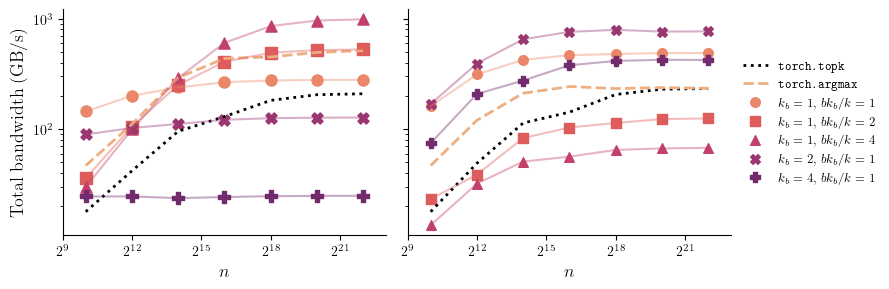

In [327]:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 3), sharey=True)
# axes = [axes]

X_AXIS, Y_AXIS = "n", "bandwidth"#, "duration_mean"
COLOR_SCHEME = {0: "flare", 1: "blend:#FF6F79,#6FB0FF"}[0]

def bandwidth(row):
    value = dict(float32=4, float16=2)[row["dtype"]]
    value *= row["n"] + row["k"]
    value *= row["batch_size"]
    value /= row["duration_mean"] / row["n_inner"]
    return value / 1e9


benchmark_df = pd.read_json("../data/synth-data-merged-v2.jsonl", lines=True)

benchmark_df.loc[:, "bandwidth"] = benchmark_df.apply(bandwidth, axis=1)

def plot_line(ax, method, method_id, color, **kwargs):
    label = r"$\texttt{torch.argmax}$" if method_id else r"$\texttt{torch.topk}$"
    # label = r"$\texttt{torch.argmax}$ (recall = $0.64$)" if method_id else r"Default (recall = $1.00$)"
    linestyle = "dashed" if method_id else "dotted"
    kwarg = {"compile": None} if method_id else {}
    default_df = filter_dataframe(
        benchmark_df, 
        method=method,
        batch_size=256,
        **kwarg,
        **kwargs,
    ).sort_values(X_AXIS)
    ax.plot(default_df[X_AXIS], default_df[Y_AXIS], color=color, label=label, linewidth=2, linestyle=linestyle)


palette = sns.color_palette(COLOR_SCHEME, as_cmap=True)
plot_line(axes[0], "approx_topk.torch_default.topk", 0, "k", k=256)
plot_line(axes[0], "approx_topk.bucket_argmax.topk_torch", 1, palette(1), k=256)


subplot(
    ax=axes[0],
    df=benchmark_df,
    x_axis=X_AXIS,
    y_axis=Y_AXIS,
    lines=[
        {"k_b": 1, "k_mult": 1},
        {"k_b": 1, "k_mult": 2},
        {"k_b": 1, "k_mult": 4},
        {"k_b": 2, "k_mult": 1},
        {"k_b": 4, "k_mult": 1},
    ],
    markers=["o", "s", "^", "X", "P", "D", "v"],
    markersize=64,
    log_x=True,
    log_y=True,
    log_y_base=10,
    legend=False,
    colors=[palette((1 + i) / 6) for i in range(5)],
    xlabel=r"$n$",
    ylabel="Total bandwidth (GB/s)",
    x_lim=(2 ** 9, 2 ** 23),
    label_fontsize=13,
    batch_size=256,
    k=64,
    k_b=[1,2,4],
    k_mult=[1,2,4],
    method="approx_topk.priority_queue.topk",
    compile=None,
)



plot_line(axes[1], "approx_topk.torch_default.topk", 0, "k", n_over_k=4)
plot_line(axes[1], "approx_topk.bucket_argmax.topk_torch", 1, palette(1), n_over_k=4)

subplot(
    ax=axes[1],
    df=benchmark_df,
    x_axis=X_AXIS,
    y_axis=Y_AXIS,
    lines=[
        {"k_b": 1, "k_mult": 1},
        {"k_b": 1, "k_mult": 2},
        {"k_b": 1, "k_mult": 4},
        {"k_b": 2, "k_mult": 1},
        {"k_b": 4, "k_mult": 1},
    ],
    # legend_keys=[
    #     r"$k_b = 1$, $bk_b / k = 1$ (recall = $0.64$)",
    #     r"$k_b = 1$, $bk_b / k = 2$ (recall = $0.79$)",
    #     r"$k_b = 1$, $bk_b / k = 4$ (recall = $0.89$)",
    #     r"$k_b = 2$, $bk_b / k = 1$ (recall = $0.73$)",
    #     r"$k_b = 4$, $bk_b / k = 1$ (recall = $0.81$)",
    # ],
    legend_keys=[
        r"$k_b = 1$, $bk_b / k = 1$",
        r"$k_b = 1$, $bk_b / k = 2$",
        r"$k_b = 1$, $bk_b / k = 4$",
        r"$k_b = 2$, $bk_b / k = 1$",
        r"$k_b = 4$, $bk_b / k = 1$",
    ],
    markers=["o", "s", "^", "X", "P", "D", "v"],
    markersize=48,
    log_x=True,
    log_y=True,
    log_y_base=10,
    legend=False,
    colors=[palette((1 + i) / 6) for i in range(5)],
    xlabel=r"$n$",
    ylabel="",
    label_fontsize=13,
    x_lim=(2 ** 9, 2 ** 23),
    batch_size=256,
    n_over_k=4,
    k_b=[1,2,4],
    k_mult=[1,2,4],
    method="approx_topk.priority_queue.topk",
    compile=None,
)


# test = benchmark_df
# # test = test[test.n_over_k == 4]
# # test = test[test.k_b == 1]
# # test = test[test.k_mult == 4]
# print(len(test))
# print(test)


_ = axes[1].legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=9)
plt.tight_layout()
plt.savefig("figures/figure-01-bandwidth.pdf")


# SparQ Tradeoff Curve

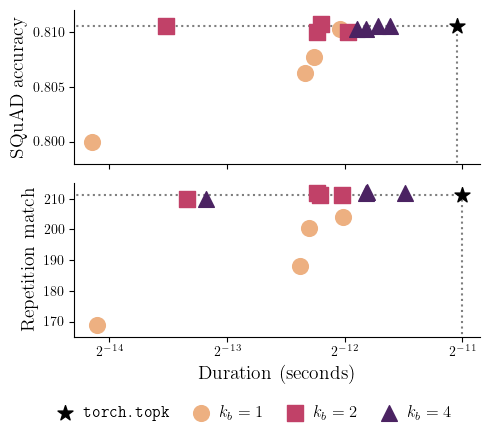

In [80]:
palette = sns.color_palette("flare", as_cmap=True)


sparq_df = pd.read_json("../data/sparq-data-merged.jsonl", lines=True)
exact_df = pd.read_json("../data/sparq-data-exact-merged.jsonl", lines=True)
sparq_df = pd.concat([sparq_df, exact_df])

print(sparq_df)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(5, 4.5), sharex=True)
if not isinstance(axes, typing.Iterable):
    axes = [axes]


for n, ax in zip([1409, 1659], axes):
    
    task = {1409: "SQuAD", 1659: "Repetition"}[n]
    y_lim = {1409: (0.798, 0.812), 1659: (165, 215)}[n]

    exact_df = sparq_df
    exact_df = exact_df[exact_df.n == n]
    exact_df = exact_df[exact_df.exact_topk == True]
    exact_df = exact_df[exact_df.compile.isin([None])]

    duration, score = exact_df.duration_mean.mean(), exact_df.score.mean()
    ax.scatter(duration, score, color="k", marker="*", s=128, label=r"$\texttt{torch.topk}$")
    plot_kwargs = {"color": "k", "linestyle": "dotted", "zorder": -2, "alpha": 0.5}
    ax.plot([duration, duration], [0, score], **plot_kwargs)
    ax.plot([0, duration], [score, score], **plot_kwargs)

    subplot(
        ax=ax,
        df=sparq_df,
        x_axis="duration_mean",
        y_axis="score",
        lines=[
            {"k_b": 1}, 
            {"k_b": 2}, 
            {"k_b": 4},
        ],
        legend_keys=[
            r"$k_b = 1$",
            r"$k_b = 2$",
            r"$k_b = 4$",
        ],
        markers=["o", "s", "^"],
        markersize=128,
        scatter_only=True,
        xlabel="Duration (seconds)" if n == 1659 else "",
        ylabel="SQuAD accuracy" if n == 1409 else "Repetition match",
        label_fontsize=14,
        log_x=True,
        y_lim=y_lim,
        legend=False,
        n=n,
        method="approx_topk.priority_queue.topk",
        interleaved=True,
        colors=[palette(i / 2) for i in range(3)],
    )

# legend = axes[len(axes) - 1].legend(fontsize=10, loc=4, framealpha=1)
# legend.get_frame().set_linewidth(0.4)
# legend.get_frame().set_edgecolor("k")

_ = axes[-1].legend(
    frameon=False, 
    loc="center left", 
    bbox_to_anchor=(-0.1, -0.5), 
    fontsize=12, 
    ncol=4, 
    columnspacing=0.9,
    handletextpad=0.1,
)
plt.tight_layout()
plt.savefig("figures/figure-02-sparq-tradeoff-squad-repetition.pdf")

# Knowledge Graph Completion Tradeoff Curve

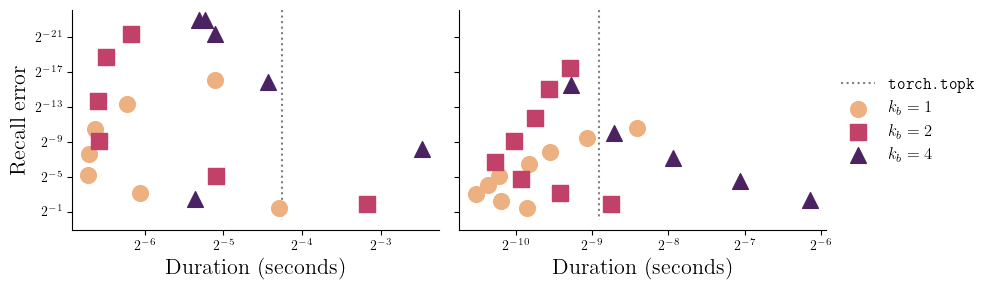

In [85]:
palette = sns.color_palette("flare", as_cmap=True)

graph_df = pd.read_json("../data/graph-data-merged.jsonl", lines=True)
graph_exact_df = pd.read_json("../data/graph-data-exact-merged.jsonl", lines=True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3), sharey=True)
if not isinstance(axes, typing.Iterable):
    axes = [axes]


k, batch_size = 100, 128

duration = graph_exact_df[(graph_exact_df.k == k) & (graph_exact_df.batch_size == batch_size)].duration_mean.mean()
plot_kwargs = {"color": "k", "linestyle": "dotted", "zorder": -2, "alpha": 0.5}
axes[0].plot([duration, duration], [0, 1], **plot_kwargs)

t = subplot(
    ax=axes[0],
    df=graph_df,
    x_axis="duration_mean",
    y_axis="error",
    lines=[
        {"k_b": 1}, 
        {"k_b": 2}, 
        {"k_b": 4},
    ],
    legend_keys=[
        r"$k_b = 1$",
        r"$k_b = 2$",
        r"$k_b = 4$",
    ],
    markers=["o", "s", "^"],
    markersize=128,
    scatter_only=True,
    xlabel="Duration (seconds)",
    ylabel="Recall error",
    log_x=True,
    log_y=True,
    legend=False,
    k=k,
    batch_size=batch_size,
    method="approx_topk.priority_queue.topk",
    interleaved=True,
    colors=[palette(i / 2) for i in range(3)],
)

# plt.gca().invert_yaxis()
k, batch_size = 256, 64

vocab_df = pd.read_json("../data/vocab-data-merged-compressed.jsonl", lines=True)
vocab_exact_df = pd.read_json("../data/vocab-data-exact-merged.jsonl", lines=True)

duration = vocab_exact_df[(vocab_exact_df.k == k) & (vocab_exact_df.batch_size == batch_size)].duration_mean.mean()
plot_kwargs = {"color": "k", "linestyle": "dotted", "zorder": -2, "alpha": 0.5, "label": r"$\texttt{torch.topk}$"}
axes[1].plot([duration, duration], [0, 1], **plot_kwargs)

t = subplot(
    ax=axes[1],
    df=vocab_df,
    x_axis="duration_mean",
    y_axis="error",
    lines=[
        {"k_b": 1}, 
        {"k_b": 2}, 
        {"k_b": 4},
    ],
    legend_keys=[
        r"$k_b = 1$",
        r"$k_b = 2$",
        r"$k_b = 4$",
    ],
    markers=["o", "s", "^"],
    markersize=128,
    scatter_only=True,
    xlabel="Duration (seconds)",
    ylabel="",
    log_x=True,
    log_y=True,
    legend=False,
    k=k,
    batch_size=batch_size,
    colors=[palette(i / 2) for i in range(3)],
)

plt.gca().invert_yaxis()
# legend = axes[len(axes) - 1].legend(fontsize=10, loc=4, framealpha=1)
# legend.get_frame().set_linewidth(0.4)
# legend.get_frame().set_edgecolor("k")
_ = axes[1].legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)
plt.tight_layout()
plt.savefig("figures/figure-04-kgc-and-vocab-tradeoff.pdf")


# Downstream Tasks

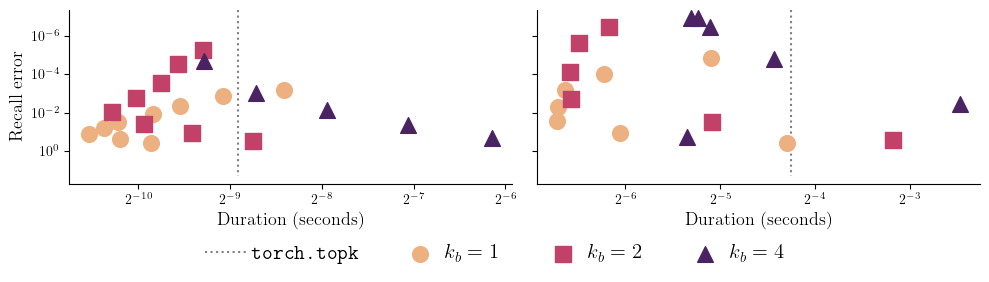

In [243]:
palette = sns.color_palette("flare", as_cmap=True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 2.5), sharey=True)


for ax, task in zip(axes, ["vocab", "graph"]):

    k = {"vocab": 256, "graph": 100}[task]
    m = {"vocab": 64, "graph": 128}[task]

    if task == "vocab":
        df = pd.read_json(f"../data/vocab-data-merged-compressed.jsonl", lines=True)
    else:
        df = pd.read_json(f"../data/graph-data-merged.jsonl", lines=True)
    exact_df = pd.read_json(f"../data/{task}-data-exact-merged.jsonl", lines=True)

    duration = exact_df[(exact_df.k == k) & (exact_df.batch_size == m)].duration_mean.mean()
    ax.plot(
        [duration, duration], 
        [0, 20], 
        color="k",
        linestyle="dotted",
        zorder=-2,
        alpha=0.5,
        label=r"$\texttt{torch.topk}$",
    )
    subplot(
        ax=ax,
        df=df,
        x_axis="duration_mean",
        y_axis="error",
        lines=[
            {"k_b": 1}, 
            {"k_b": 2}, 
            {"k_b": 4},
        ],
        legend_keys=[
            r"$k_b = 1$",
            r"$k_b = 2$",
            r"$k_b = 4$",
        ],
        markers=["o", "s", "^"],
        markersize=128,
        scatter_only=True,
        xlabel="Duration (seconds)",
        ylabel="Recall error" if task == "vocab" else "",
        label_fontsize=13,
        log_x=True,
        log_y=True,
        log_y_base=10,
        legend=False,
        k=k,
        batch_size=m,
        colors=[palette(i / 2) for i in range(3)],
    )
plt.gca().invert_yaxis()
handles, labels = ax.get_legend_handles_labels()
legend = fig.legend(
    handles, 
    labels, 
    loc="lower center",
    frameon=False,
    fontsize=15,
    ncol=4,
    columnspacing=2,
    handletextpad=0.2,
    bbox_to_anchor=(0.5, -0.15),
)

plt.tight_layout()
fig.savefig("figures/figure-04-kgc-and-vocab-tradeoff.pdf", bbox_extra_artists=(legend,), bbox_inches="tight")
    

# Theoretical results

In [445]:
# SMALL_K = 256
# LARGE_K = 1048576
# REPS = 25

# def simulated_recall(row):
#     result = theoretical_models.recall.simulation(
#         k=row["k"],
#         n=row["n"],
#         b=row["b"],
#         k_b=row["k_b"],
#         m=row["batch_size"],
#         reps=25,
#     )
#     # print(row["k"], row["n"], row["b"], row["k_b"], row["batch_size"], result[0])
#     return result[0]


# def simulated_error(row):
#     return 1 - row["recall"]




# synth_df = pd.read_json("../data/synth-data-merged-v2.jsonl", lines=True)
# synth_df = synth_df[synth_df.k.isin([SMALL_K, LARGE_K])]
# synth_df.loc[:, "recall"] = synth_df.apply(simulated_recall, axis=1)
# synth_df.loc[:, "error"] = synth_df.apply(simulated_error, axis=1)


# for feature in ["k", "n", "batch_size", "k_mult"]:
#     print(f"{feature}:", [*set(synth_df[feature])])

k: [256, 1048576]
n: [1024, 4096, 262144, 16384, 65536, 1048576, 4194304]
batch_size: [256, 1]
k_mult: [32, 1, 2, 4, 8, 16]


/tmp/ipykernel_1283293/1922939055.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  _ = axes[1].legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)


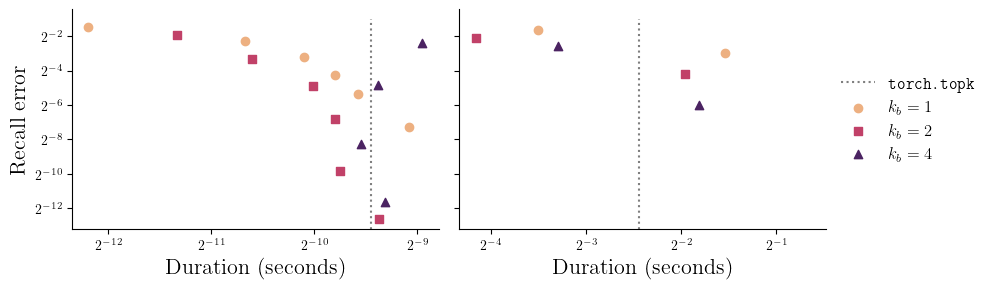

In [478]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3), sharey=True)
if not isinstance(axes, typing.Iterable):
    axes = [axes]

palette = sns.color_palette("flare", as_cmap=True)

exact_df = synth_df
exact_df = exact_df[exact_df.k == exact_df.k_b]

for ax, k in zip(axes, [SMALL_K, LARGE_K]):

    ylabel = "Recall error" if k == SMALL_K else ""
    n = 16384 if k == SMALL_K else 4194304
    batch_size = 256

    duration = exact_df[(exact_df.k == k) & (exact_df.n == n) & (exact_df.batch_size == batch_size)].duration_mean.mean()
    plot_kwargs = {"color": "k", "linestyle": "dotted", "zorder": -2, "alpha": 0.5, "label": r"$\texttt{torch.topk}$"}
    ax.plot([duration, duration], [0, 0.5], **plot_kwargs)


    subdf = subplot(
        ax=ax,
        df=synth_df,
        x_axis="duration_mean",
        y_axis="error",
        lines=[
            {"k_b": 1}, 
            {"k_b": 2}, 
            {"k_b": 4},
        ],
        legend_keys=[
            r"$k_b = 1$",
            r"$k_b = 2$",
            r"$k_b = 4$",
        ],
        markers=["o", "s", "^"],
        scatter_only=True,
        xlabel="Duration (seconds)",
        ylabel=ylabel,
        log_x=True,
        log_y=True,
        legend=False,
        k=k,
        n=n,
        batch_size=batch_size,
        method="approx_topk.priority_queue.topk",
        colors=[palette(i / 2) for i in range(3)],
    )

    _ = axes[1].legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)
    plt.tight_layout()
    plt.savefig("figures/figure-03-theoretical-tradeoff.pdf")



# Theoretical V2    

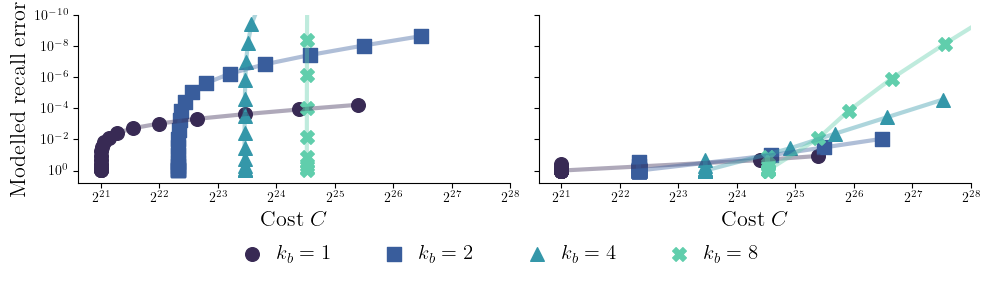

In [217]:
palette = sns.color_palette("mako", as_cmap=True)

def simulated_recall(row):
    return theoretical_models.recall.model(
        k=int(row["k"]),
        n=int(row["n"]),
        b=int(row["b"]),
        k_b=int(row["k_b"]),
        m=int(row["batch_size"]),
    )

def simulated_error(row):
    return 1 - row["simulated_recall"]

def cost_basic(row):
    return theoretical_models.cost_basic.approx_topk(
        k=row["k"],
        n=row["n"],
        m=row["batch_size"],
        b=row["b"],
        k_b=row["k_b"],
    )

def cost_serial(row):
    return theoretical_models.cost_serial.approx_topk(
        k=row["k"],
        n=row["n"],
        m=row["batch_size"],
        b=row["b"],
        k_b=row["k_b"],
    )

def cost_parallel(row):
    return theoretical_models.cost_parallel.approx_topk(
        k=row["k"],
        n=row["n"],
        m=row["batch_size"],
        b=row["b"],
        k_b=row["k_b"],
    )


configs = {
    "k": [2 ** i for i in range(1, 21)],
    "n": [2 ** i for i in range(24)],
    "b": [2 ** i for i in range(28)],
    "k_b": [1, 2, 4, 8],
    "batch_size": [1, 32, 256],
}
permutations = [*itertools.product(*configs.values())]

df = pd.DataFrame(permutations, columns=[*configs.keys()])
df = df[df.k < df.n]
df = df[df.b < df.n]


df.loc[:, "cost_basic"] = df.apply(cost_basic, axis=1)
df.loc[:, "cost_serial"] = df.apply(cost_serial, axis=1)
df.loc[:, "cost_parallel"] = df.apply(cost_parallel, axis=1)
df.loc[:, "n_over_k"] = df.apply(lambda r: r["n"] / r["k"], axis=1)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 2.5), sharey=True)
if not isinstance(axes, typing.Iterable):
    axes = [axes]


for config_id, config in enumerate([
  
    {"n": 1048576, "k": 64, "batch_size": 1},
    {"n": 1048576, "n_over_k": 8, "batch_size": 1}
]):
    ax = axes[config_id]
    _df = filter_dataframe(df, **config)
    _df.loc[:, "simulated_recall"] = _df.apply(simulated_recall, axis=1)
    _df.loc[:, "simulated_error"] = _df.apply(simulated_error, axis=1) 

    _ = subplot(
        ax=ax,
        df=_df,
        x_axis="cost_serial",
        y_axis="simulated_error",
        lines=[
            {"k_b": 1}, 
            {"k_b": 2}, 
            {"k_b": 4},
            {"k_b": 8},
        ],
        legend_keys=[
            r"$k_b = 1$",
            r"$k_b = 2$",
            r"$k_b = 4$",
            r"$k_b = 8$",
        ],
        markers=["o", "s", "^", "X"],
        markersize=96,
        xlabel=r"Cost $C$",
        ylabel="Modelled recall error" if config_id == 0 else "",
        legend=False,
        log_x=True,
        log_y=True,
        log_y_base=10,
        colors=[palette((i + 1) / 5) for i in range(4)],
        line_kwargs={"linewidth": 3},
    )
    ax.set_ylim(bottom=10**-10)
    ax.set_xlim(right=2**28)

plt.gca().invert_yaxis()


handles, labels = ax.get_legend_handles_labels()
legend = fig.legend(
    handles, 
    labels, 
    loc="lower center",
    frameon=False,
    fontsize=15,
    ncol=4,
    columnspacing=2,
    handletextpad=0.2,
    bbox_to_anchor=(0.5, -0.15),
)

plt.tight_layout()
fig.savefig(
    "figures/figure-03-theoretical-tradeoff.pdf", 
    bbox_extra_artists=(legend,), 
    bbox_inches="tight",
)

# Theoretical Appendix Sweep

In [177]:
configs = {
    "k": [2 ** i for i in range(21)],
    "n": [2 ** i for i in range(12, 20)],
    "b": [2, 4, 8, 16],
    # "b": [2 ** i for i in range(20)],
    # "b": [2 ** i for i in range(28)],
    "k_b": [1, 2, 4, 8],
    "batch_size": [1],
}

df = pd.DataFrame([*itertools.product(*configs.values())], columns=[*configs.keys()])
df = df[df.k < df.n]
df = df[df.b < df.n]
df = df[df.k >= df.k_b]

df.loc[:, "simulated_recall"] = df.apply(
    lambda row: theoretical_models.recall.model(
        k=row["k"],
        n=row["n"],
        m=row["batch_size"],
        b=row["b"],
        k_b=row["k_b"],
    ),
    axis=1,
)
df.loc[:, "simulated_error"] = df.apply(lambda row: 1 - row["simulated_recall"], axis=1)
df.loc[:, "n_over_k"] = df.apply(lambda r: r["n"] / r["k"], axis=1)

for cost_function in ["cost_basic", "cost_serial", "cost_parallel"]:

    df.loc[:, cost_function] = df.apply(
        lambda row: getattr(theoretical_models, cost_function).approx_topk(
            k=row["k"],
            n=row["n"],
            m=row["batch_size"],
            b=row["b"],
            k_b=row["k_b"],
        ),
        axis=1,
    )

In [ ]:
palette = sns.color_palette("mako", as_cmap=True)
conditions = {0: {"k": 64}, 1: {"n_over_k": 16}, 2: {"n_over_k": 4}}

for cost_function in ["cost_parallel"]:
# for cost_function in ["cost_basic", "cost_serial", "cost_parallel"]:

    fig, axes = plt.subplots(
        nrows=len(configs["n"]), 
        ncols=3, 
        figsize=(11.5, 16), 
        sharey=True,
    )

    for row_id, (n, row_axes) in enumerate(zip(configs["n"], axes)):
        for col_id, ax in enumerate(row_axes):

            col_name = {
                0: r"$k = 64$",
                1: r"$k = n / 16$",
                2: r"$k = n / 4$",
            }[col_id]

            xlabel = f"Cost $C$\n({col_name})"
            ylabel = "Recall error\n($n = 2^{" + str(int(math.log2(n))) + "})$"

            _df = filter_dataframe(df, n=n, **conditions[col_id])

            subplot(
                ax=ax,
                df=_df,
                x_axis=cost_function,
                y_axis="simulated_error",
                lines=[
                    {"k_b": 1}, 
                    {"k_b": 2}, 
                    {"k_b": 4},
                    {"k_b": 8},
                ],
                legend_keys=[
                    r"$k_b = 1$",
                    r"$k_b = 2$",
                    r"$k_b = 4$",
                    r"$k_b = 8$",
                ],
                markers=["o", "s", "^", "X"],
                markersize=64,
                xlabel=xlabel if row_id == len(axes) - 1 else "",
                ylabel=fr"{ylabel}" if col_id == 0 else "",
                legend=False,
                log_x=True,
                log_y=True,
                log_y_base=10,
                colors=[palette((i + 1) / 5) for i in range(4)],
                line_kwargs={"linewidth": 1},
            )
            ax.set_ylim(bottom=10**-6)
            sns.despine()

    plt.gca().invert_yaxis()


    handles, labels = ax.get_legend_handles_labels()
    legend = fig.legend(
        handles, 
        labels, 
        loc="lower center",
        frameon=False,
        fontsize=15,
        ncol=4,
        columnspacing=2,
        handletextpad=0.2,
        bbox_to_anchor=(0.5, -0.03),
    )
    plt.tight_layout()
    # fig.savefig(
    #     f"figures/appendix-tradeoff-{cost_function}.pdf", 
    #     bbox_extra_artists=(legend,), 
    #     bbox_inches="tight",
    # )
    # plt.cla()
    # plt.clf()
            


# Appendix Sweep, V2

In [309]:
palette = sns.color_palette("mako", as_cmap=True)

df = (pd.read_json("../data/theoretical_models.jsonl", lines=True)
      .pipe(lambda d: d.assign(error_model=1-d["recall_model"]))
      .pipe(lambda d: d.assign(error_simulation=1-d["recall_simulation"]))
      .pipe(lambda d: d.assign(n_over_k=d["n"] / d["k"]))
      .pipe(lambda d: d.assign(kb=d["k"] * d["b"]))
)

# df = df[df.n.gt(df.kb)]

n_list = sorted([*set(df.n)])

conditions = {0: {"k": 256}, 1: {"n_over_k": 16}, 2: {"n_over_k": 4}}

for cost_function in ["cost_basic", "cost_serial", "cost_parallel"]:

    fig, axes = plt.subplots(
        nrows=len(n_list), 
        ncols=3, 
        figsize=(12, 16), 
        # sharey=True,
    )

    for row_id, (n, row_axes) in enumerate(zip(n_list, axes)):
        for col_id, ax in enumerate(row_axes):

            col_name = {
                0: r"$k = 256$",
                1: r"$k = n / 16$",
                2: r"$k = n / 4$",
            }[col_id]

            duration = filter_dataframe(df, algorithm="exact", n=n, **conditions[col_id])[cost_function].mean()
            plot_kwargs = {"color": "k", "linestyle": "dotted", "zorder": -2, "alpha": 0.5, "label": r"top-$k$"}
            ax.plot([duration, duration], [0, 1], **plot_kwargs)

            _df = filter_dataframe(df, algorithm="approx", n=n, **conditions[col_id])

            subplot(
                ax=ax,
                df=_df,
                x_axis=cost_function,
                y_axis="error_simulation",
                lines=[
                    {"k_b": 1}, 
                    {"k_b": 2}, 
                    {"k_b": 4},
                    {"k_b": 8},
                ],
                legend_keys=[
                    r"$k_b = 1$",
                    r"$k_b = 2$",
                    r"$k_b = 4$",
                    r"$k_b = 8$",
                ],
                markers=["o", "s", "^", "X"],
                markersize=64,
                # xlabel=xlabel if row_id == len(axes) - 1 else "",
                # ylabel=fr"{ylabel}" if col_id == 0 else "",
                xlabel="Cost $C$" if row_id == len(axes) - 1 else "",
                ylabel="Modelled recall error" if col_id == 0 else "",
                legend=False,
                log_x=True,
                log_y=True,
                log_y_base=10,
                colors=[palette((i + 1) / 5) for i in range(4)],
                line_kwargs={"linewidth": 3},
                remove_last=1,
            )
            # ax.set_ylim(bottom=10**-6)
            ax.text(
                0.05, 
                0.95, 
                f"$n=2^{{{math.log2(n):.0f}}}$, {col_name}", 
                va="top", 
                ha="left", 
                transform=ax.transAxes, 
                fontsize=13,
            ).set_bbox({"facecolor": "w", "linewidth": 0.2})



            sns.despine()

            ax.invert_yaxis()

    handles, labels = ax.get_legend_handles_labels()
    legend = fig.legend(
        handles, 
        labels, 
        loc="lower center",
        frameon=False,
        fontsize=18,
        ncol=5,
        columnspacing=2.2,
        handletextpad=0.3,
        bbox_to_anchor=(0.5, -0.05),
    )
    plt.tight_layout()
    fig.savefig(
        f"figures/appendix-tradeoff-{cost_function}-with-exact.pdf", 
        bbox_extra_artists=(legend,), 
        bbox_inches="tight",
    )
    plt.cla()
    plt.clf()

<Figure size 1200x1600 with 0 Axes>

<Figure size 1200x1600 with 0 Axes>

<Figure size 1200x1600 with 0 Axes>

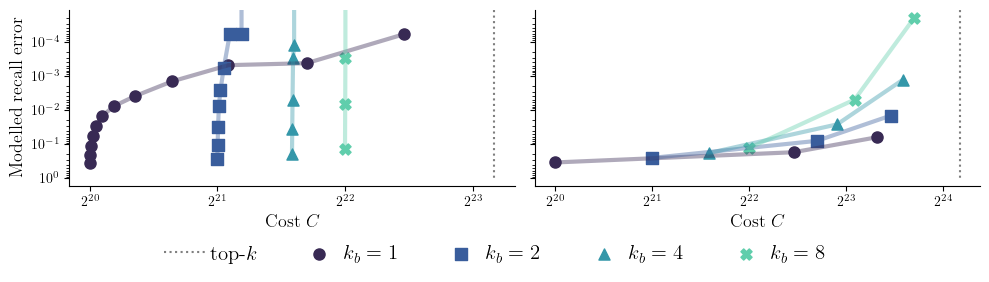

In [324]:
palette = sns.color_palette("mako", as_cmap=True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 2.5), sharey=True)
if not isinstance(axes, typing.Iterable):
    axes = [axes]

X_AXIS = "cost_basic"


for config_id, config in enumerate([
  
    {"n": 1048576, "k": 256},
    {"n": 1048576, "n_over_k": 8}
]):
    ax = axes[config_id]

    duration = filter_dataframe(df, algorithm="exact", **config)[X_AXIS].mean()
    plot_kwargs = {"color": "k", "linestyle": "dotted", "zorder": -2, "alpha": 0.5, "label": r"top-$k$"}
    ax.plot([duration, duration], [0, 1], **plot_kwargs)

    
    _df = filter_dataframe(df, algorithm="approx", **config)

    _ = subplot(
        ax=ax,
        df=_df,
        x_axis=X_AXIS,
        y_axis="error_simulation",
        lines=[
            {"k_b": 1}, 
            {"k_b": 2}, 
            {"k_b": 4},
            {"k_b": 8},
        ],
        legend_keys=[
            r"$k_b = 1$",
            r"$k_b = 2$",
            r"$k_b = 4$",
            r"$k_b = 8$",
        ],
        markers=["o", "s", "^", "X"],
        markersize=64,
        xlabel="Cost $C$",
        ylabel="Modelled recall error" if config_id == 0 else "",
        label_fontsize=13,
        legend=False,
        log_x=True,
        log_y=True,
        log_y_base=10,
        colors=[palette((i + 1) / 5) for i in range(4)],
        line_kwargs={"linewidth": 3},
        remove_last=1,
    )
plt.gca().invert_yaxis()
    # ax.invert_yaxis()
    # if config_id:
    #     ax.set_xlim(right=2 ** 24)
    # else:
    #     ax.set_xlim(right=2 ** 23)


    


handles, labels = ax.get_legend_handles_labels()
legend = fig.legend(
    handles, 
    labels, 
    loc="lower center",
    frameon=False,
    fontsize=15,
    ncol=5,
    columnspacing=2,
    handletextpad=0.2,
    bbox_to_anchor=(0.5, -0.15),
)

plt.tight_layout()
fig.savefig(
    "figures/figure-03-theoretical-tradeoff-k256.pdf", 
    bbox_extra_artists=(legend,), 
    bbox_inches="tight",
)



# Appendix Plots!

In [326]:
from typing import *
from math import log2
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns




def tidy(*axs: matplotlib.axes.Axes) -> None:
    for ax in axs:
        NAME_MAP = dict(
            duration="Duration (s)",
            topk_size="$n$",
            j="$k_b$",
            k="$k$",
            k_mult="$b k_b / k$",
            cost_basic=r"$C^{\textrm{basic}}$",
            cost_serial=r"$C^{\textrm{serial}}$",
            cost_parallel=r"$C^{\textrm{parallel}}$",
        )
        def _get(name: str) -> str:
            return NAME_MAP.get(name, name)
        ax.set_xlabel(_get(ax.get_xlabel()))
        ax.set_ylabel(_get(ax.get_ylabel()))
        if ax.title is not None:
            ax.title.set_text(_get(ax.title.get_text()))

method_to_name = {
    'approx_topk.torch_default.topk': "torch",
    'approx_topk.bucket_argmax.topk_torch': "argmax",
    'approx_topk.priority_queue.topk': "queue",
}

df = (pd.concat([pd.read_json(f, lines=True) for f in Path("../data/generic2").glob("*.jsonl")])
    .reset_index(drop=True)
    .pipe(lambda d: d.assign(
        method=d.method.apply(method_to_name.__getitem__),
        duration=d.duration.apply(np.mean) / d.n_inner,
        duration_stderr=d.duration.apply(lambda d: np.std(d)/np.sqrt(len(d))) / d.n_inner,
    ))
    .pipe(lambda d: d.assign(
        bandwidth=d.dtype.apply(dict(float32=4, float16=2).__getitem__) * (d.topk_size + d.k) * d.batch_size / d.duration,
    ))
    .pipe(lambda d: d[(d.method != "argmax") | (d.compile == "default")])
    .drop(columns=["args", "compile", "cuda_graphs", "n_warmup", "n_outer", "n_inner", "n_inner_inputs", "dtype", "device"])
)
assert (df.groupby(["batch_size", "topk_size", "k", "j", "k_mult", "method"]).apply(len, include_groups=False) == 1).all()
print(len(df))
print(df.method.unique())
df.head()

ValueError: No objects to concatenate